#1 Input file format for linear modelling

In this section, we read the globalbedo (MERIS and VGT) data do a brief examination of the data.

In particular. we are concerned with putting the data in a format that simplifies GA processing.

The first stage of this requires the observation and other data to be stacked into netcdf files with data of shape `(Nt,Nx,Ny)` where `Nt` is the number of time samples, and `Nx` and `Ny` are the spatial dimensions. We also define `time` as the number of days after a baseline (Jan 1 1998 here).

The input data are currently in netcdf files of form `rootgrp.variables[Nt][Nx,Ny]`.

We use the script [convertMe.py](convertMe.py) to achieve the conversion, and also to convert all 'standard deviation' or 'variance' files to weights (i.e. $\frac{1}{sd^2}$).

It assumes that the filenames are as currently supplied, and that all data are in a directory [`data`](data). It writes the re-formatted data to [`inputs`](inputs). This script should be modified to run on all supplied netcdf input data files.

The real reason for doing this is that when we open the new data files, we are able (if needed) tp memory-mapped in the python code, so, assuming the data are on a relatively fast (e.g. local, e.g. SSD) disk, the data access is greatly speeded up and memory requirements reduced. This is important when dealing with *very large* datasets.

There is generally a limit on the number of files that can be opened by a single process (typically 256). When using memory mapped files, we must make sure we close the files when we no longer need access to the data. We should really do this anyway, but it often becomes important in cases like this.

A potential issue is that the files created might well be of size > 2GB, which some operating systems may have a problem with. The answer is to use a better operating system.

We will now read some example files:

In [1]:
import os,os.path
from convertMe import ensure_dir
import sys
import netCDF4
odir = 'data'
# -*- coding: utf-8 -*-
url = u'http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY'

dirs = {'vgt':'bbdr.vgt','meris':'bbdr.meris','ga':'ga.brdf','prior':'prior'}
tile = 'h18v04..600_600..256_256'

for sensor in ['vgt','meris','ga','prior']:
    for dtype in ['VZA','SZA','RAA','Kgeo_BRDF_NIR','Kgeo_BRDF_SW','Kgeo_BRDF_VIS',\
                  'Kvol_BRDF_NIR','Kvol_BRDF_SW','Kvol_BRDF_VIS',\
                  'sig_BB_NIR_NIR', 'sig_BB_NIR_SW', 'sig_BB_SW_SW',\
                  'sig_BB_VIS_NIR', 'sig_BB_VIS_SW', 'sig_BB_VIS_VIS','snow_mask']:

        config = {'tile':tile,'sensor':sensor,'type':dtype}

        file = 'bbdr.{sensor}..{type}..{tile}.nc'.format(**config)
        odir = odir + url.replace('http:/','').replace('/public/globalbedo','') \
                    + '/' + dirs[sensor] + '/' + tile 
        ensure_dir(odir)
        ofile = odir + '/' + file

        furl = url + '/' + dirs[sensor] + '/' + tile + '/' + dtype + '/' + file

        if os.path.isfile(ofile):
            print ofile,'exists'
            sys.stdout.flush()
        else:
            print 'get from',furl
            sys.stdout.flush()
            try:
                rootgrp = netCDF4.Dataset(furl.decode('utf-8', 'ignore'))
                datasets = rootgrp.variables.keys()
                nx = len(rootgrp.dimensions['x'])
                ny = len(rootgrp.dimensions['y'])
                nt = len(datasets)
                print nx,ny,nt
                sys.stdout.flush()
            except:
                print 'failed',furl
                sys.stdout.flush()


get from http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/VZA/bbdr.vgt..VZA..h18v04..600_600..256_256.nc
failed http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/VZA/bbdr.vgt..VZA..h18v04..600_600..256_256.nc
get from http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/SZA/bbdr.vgt..SZA..h18v04..600_600..256_256.nc
failed http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/SZA/bbdr.vgt..SZA..h18v04..600_600..256_256.nc
get from http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/RAA/bbdr.vgt..RAA..h18v04..600_600..256_256.nc
failed http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/RAA/bbdr.vgt..RAA..h18v04..600_600..256_256.nc
get from http://gws-access.cems.rl.ac.uk/public/globalbedo/stackXY/bbdr.vgt/h18v04..600_600..256_256/Kgeo_BRDF_NIR/bbd

In [2]:
run convertMe.py

In [3]:
%matplotlib inline 

import numpy as np
import scipy
import pylab as plt
import numpy.ma as ma
import datetime
import glob
# easy_install spectral
import spectral.io.envi as envi
import os.path

def doy2date(doys,baseyear=1998):
    doys = doys[:]
    # convert doys list to date field
    year = baseyear
    return np.array([datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1) \
                   for doy in doys])

# set up some dictionaries to access the data
data = {}

def readenvi(m_files): 
    data = {'data':[],'rootgrp':[],'time':[],'baseyear':[],'filenames':[],'sensor':[]}
    for i in xrange(len(m_files)):
        data['rootgrp'].append(envi.open (m_files[i]))
        rootgrp = data['rootgrp'][-1]
        data['data'].append(rootgrp.open_memmap())
        data['time'] = np.array(rootgrp.metadata['time']).astype(float)
        data['baseyear'].append(int(rootgrp.metadata['baseyear']))
        data['sensor'].append(rootgrp.metadata['sensor'])
        data['filenames'].append(m_files[i])
    return data

def plotdata(data,log=False,band=0,set=0,row=0,col=0):
    sensor = data['sensor'][set]
    print len(data['data']),data['data'][set].shape
    plt.figure(figsize=(15,8))
    plt.title(sensor)
    if log: 
        plt.imshow(np.log(data['data'][set][:,:,band]),interpolation='nearest')
    else:
        plt.imshow(data['data'][set][:,:,band],interpolation='nearest')
    plt.colorbar()
    plt.figure(figsize=(15,8))
    plt.plot(doy2date(data['time'],baseyear=data['baseyear'][set]),data['data'][set][row,col,:],'r+')
    if log: plt.semilogy()


In [4]:
m_files = ['inputs/bbdr.meris..BB_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.meris..Kvol_BRDF_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.meris..Kgeo_BRDF_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.meris..weight_BB_NIR_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.meris..snow_mask..h18v04..600_600..256_256.hdr']

data['meris'] = readenvi(m_files)

FileNotFoundError: Unable to locate file "inputs/bbdr.meris..BB_NIR..h18v04..600_600..256_256.hdr". If the file exists, use its full path or place its directory in the SPECTRAL_DATA environment variable.

In [5]:
plotdata(data['meris'],set=0,band=-1000,col=50,row=125)

KeyError: 'meris'

5 (256, 256, 3902)


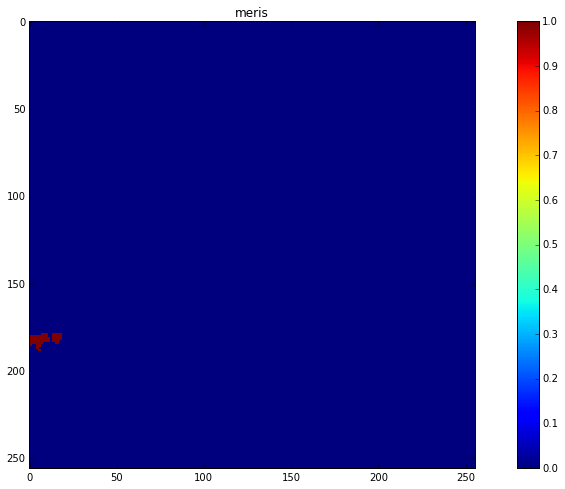

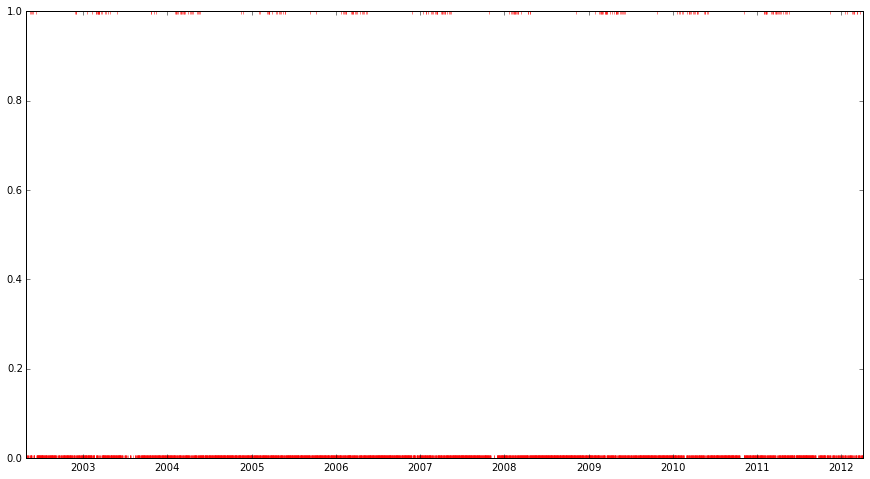

In [5]:
plotdata(data['meris'],set=4,band=-1000,col=50,row=125)

5 (256, 256, 9129)


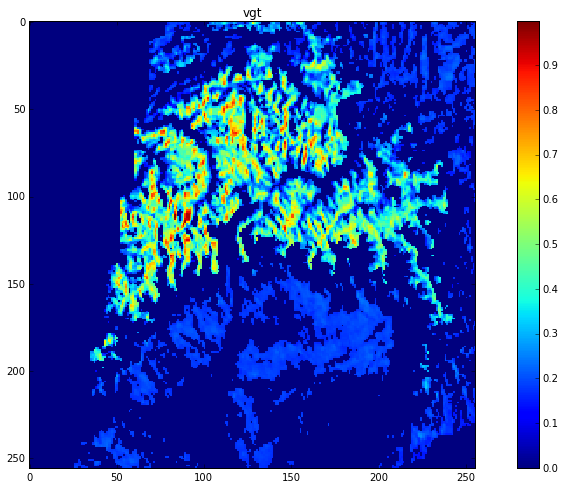

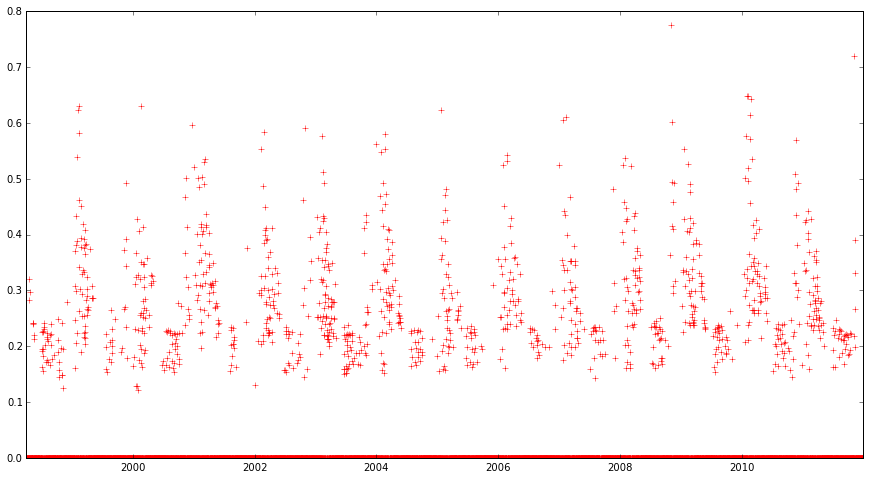

In [6]:
v_files = ['inputs/bbdr.vgt..BB_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.vgt..Kvol_BRDF_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.vgt..Kgeo_BRDF_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.vgt..weight_BB_NIR_NIR..h18v04..600_600..256_256.hdr',\
           'inputs/bbdr.vgt..snow_mask..h18v04..600_600..256_256.hdr']

data['vgt'] = readenvi(v_files)
plotdata(data['vgt'],set=0,band=-10,col=50,row=125)

5 (256, 256, 9129)


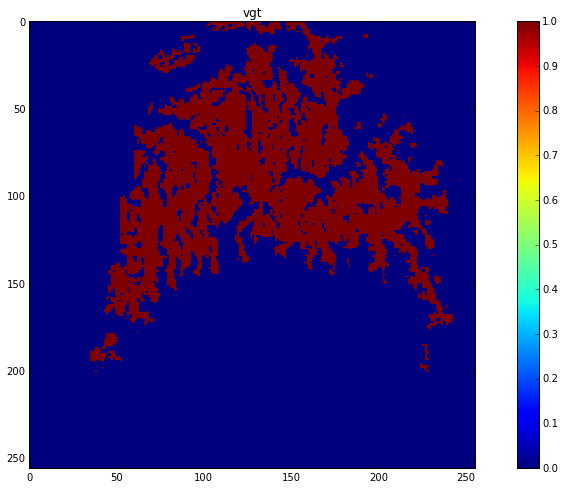

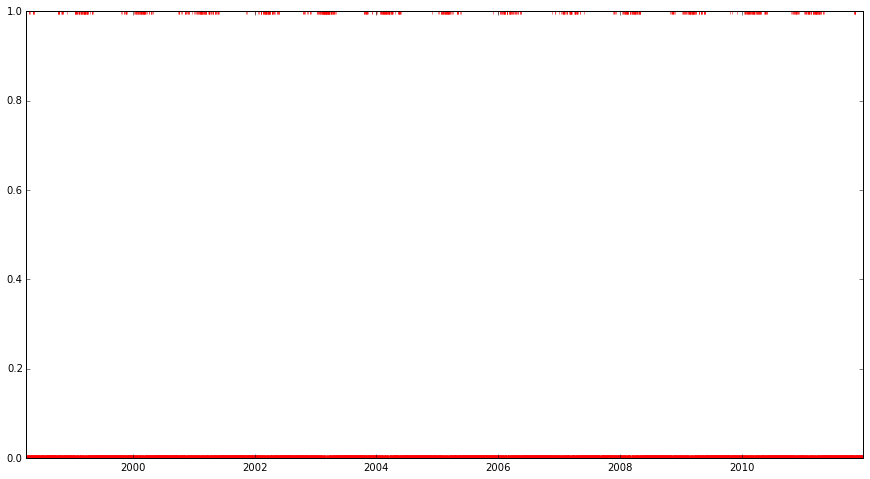

In [7]:
plotdata(data['vgt'],set=4,band=-10,col=50,row=125)

3 (256, 256, 644)


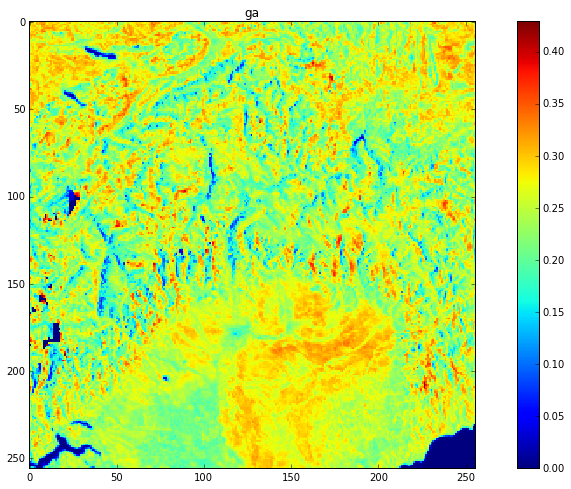

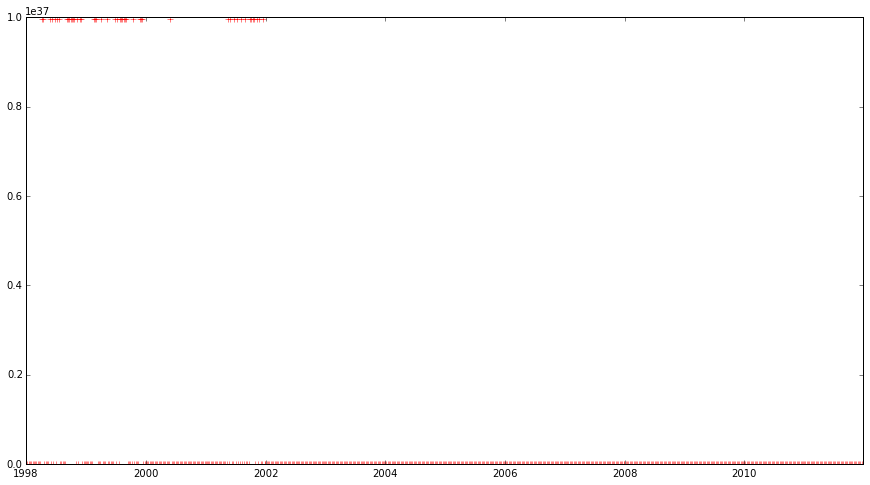

In [8]:
ga_files = np.sort(glob.glob('inputs/ga.brdf.NoSnow..mean_NIR_f[0-2]..h18v04..600_600..256_256.hdr'))

data['ga mean'] = readenvi(ga_files)

plotdata(data['ga mean'],set=0,band=7,col=50,row=125)

3 (256, 256, 644)


/Users/plewis/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


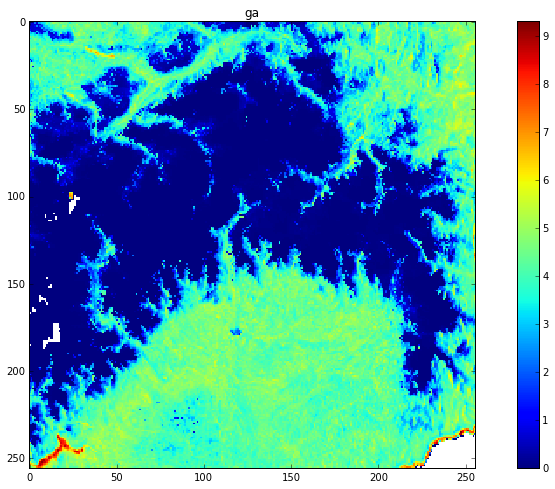

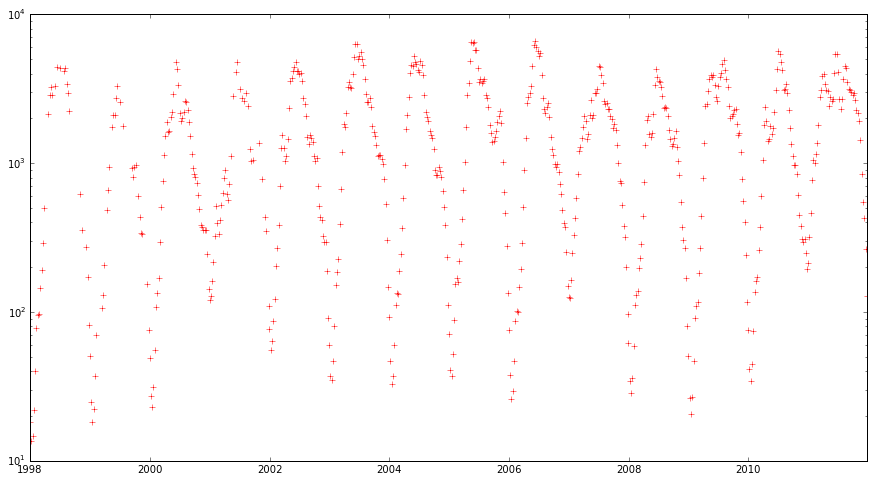

In [9]:
gawt_files = ['inputs/ga.brdf.NoSnow..weight_NIR_f{0}_NIR_f{0}..h18v04..600_600..256_256.hdr'\
              .format(i) for i in xrange(3)]

data['ga weight'] = readenvi(gawt_files)

plotdata(data['ga weight'],set=0,band=1,log=True)

3 (256, 256, 46)


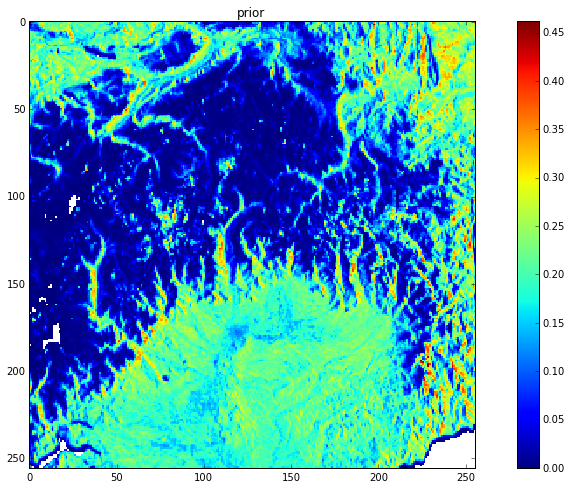

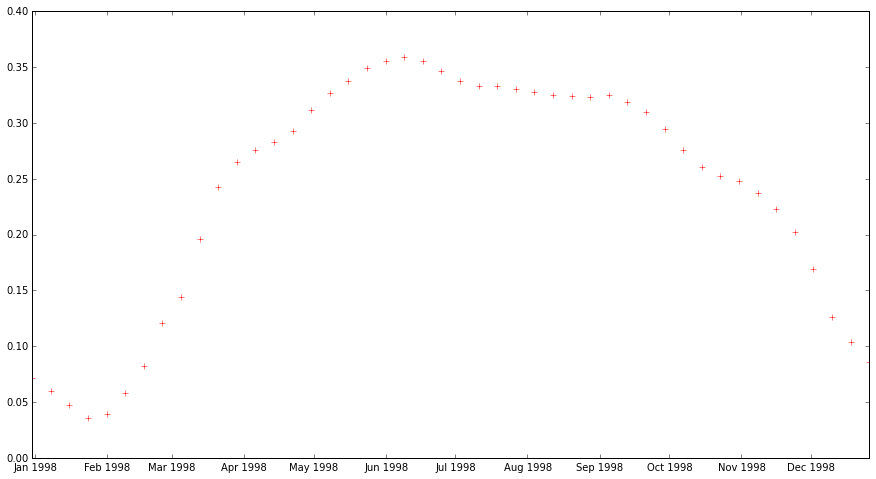

In [10]:
pws_files = np.sort(glob.glob('inputs/prior.1km.NoSnow..MEAN:_BAND_8_PARAMETER_F?..h18v04..600_600..256_256.hdr'))

data['prior mean'] = readenvi(pws_files)

plotdata(data['prior mean'],set=0,band=0)

3 (256, 256, 46)


/Users/plewis/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


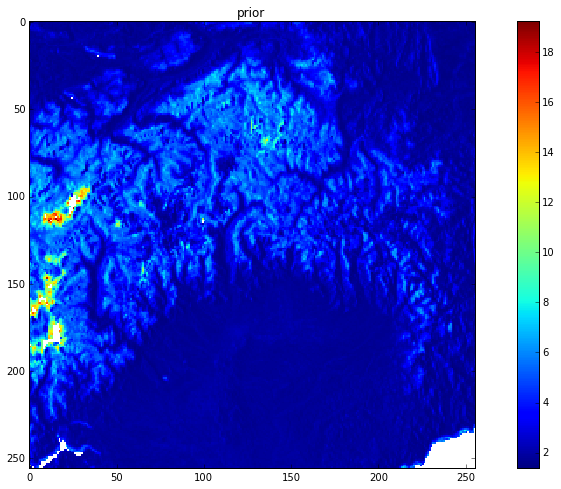

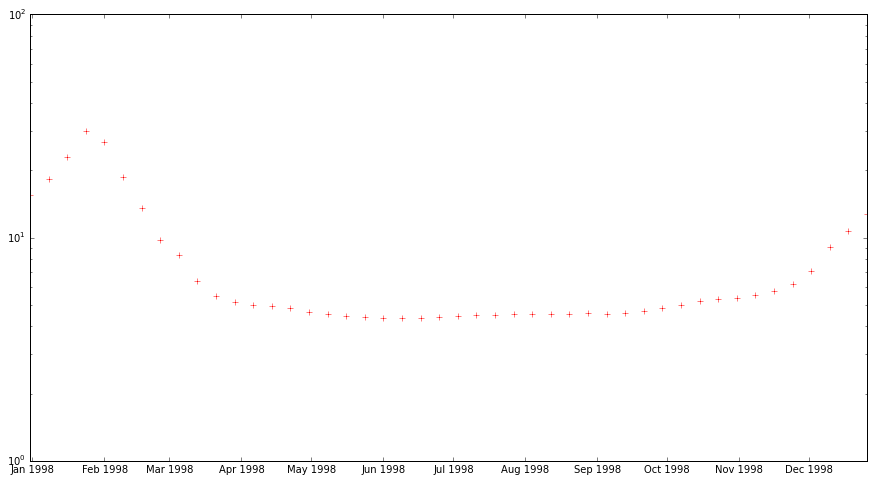

In [11]:
spws_files = np.sort(glob.glob('inputs/prior.1km.NoSnow..weight:_BAND_8_PARAMETER_F?..h18v04..600_600..256_256.hdr'))

data['prior weight'] = readenvi(spws_files)

plotdata(data['prior weight'],set=0,band=0,log=True)

In [12]:
# tidy up
for k in data.keys():
    nd = data[k]['data']
    for kk in data[k].keys():
        del kk
    del k
del data